<a href="https://colab.research.google.com/github/koad7/NLP_PYTORCH/blob/main/Embeddings_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from transformers import BertModel, BertTokenizer
    import nltk
except ImportError:
    !pip install  -q  transformers nltk
    from transformers import BertModel, BertTokenizer
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example text

paragraph = '''Police launched a battery investigation
Yahoo has confirmed that Spears filed a police report after the confrontation, which apparently identifies Spurs director of team security Damian Smith as the person who allegedly backhanded the singer.

"On July 5, 2023, at approximately 11 p.m., LVMPD officers responded to a property in the 3700 block of Las Vegas Boulevard regarding a battery investigation," a police spokesperson said on Thursday. "The incident has been documented on a police report and no arrest or citations have been issued."

A criminal investigation is being conducted. TMZ, meanwhile, has reported the case will "likely" be sent to the district attorney's office.

An eyewitness backs up Spears's version
A man who saw everything go down at the Aria hotel told TMZ he saw Spears approach Wembanyama. Purportedly, she leaned in and said, "Excuse me, sir ... excuse me, sir." Spears apparently touched Wembanyama's back and that's when the witness claimed to see a Spurs security guard hit her in the face causing Spears's sunglasses to fly off.

Sam Asghari watched the whole thing go down, too
Spears's husband blasted the "coward" who allegedly hit his wife, but said Wembanyama isn't at fault.

"The violent behavior of an out-of-control security guard should not cast a shadow on the accomplishment of a great young man on the rise. The blame should fall on the coward who did this, the people who hired him without proper vetting, and a systemic culture of disregard for women within sports and entertainment," he wrote, in part, on Instagram.

"I can't imagine a scenario where an unarmed female fan showing any kind of excitement or appreciation for a celebrity would cause her to be physically assaulted, much less being hit in the face for tapping someone on the shoulder," he added.'''



In [2]:
import torch
import numpy as np

The code snippet below demonstrates how to calculate the embedding matrix for a given paragraph using BERT. Let's go through the steps:

1. Tokenization:
   The paragraph is tokenized using the BERT tokenizer, which splits the text into a list of tokens.

2. Loading the Pre-trained Model:
   The BERT model (`BertModel`) is loaded with the pre-trained weights from the `'bert-base-uncased'` variant. By setting `output_hidden_states=True`, the model will also return the hidden states for all layers.

3. Converting Tokens to Tensor:
   The list of tokens is converted to their corresponding vocabulary indices using `convert_tokens_to_ids`. Then, the indexed tokens are converted to a PyTorch tensor.

4. Hidden State Prediction:
   The model is used to predict the hidden states for each layer of the BERT model. The `outputs` variable captures the model's output, and `hidden_states` extracts the hidden states from the third output element.

5. Extracting Token Embeddings:
   The hidden states tensor (`hidden_states`) has a shape of `[num_layers x 1 x sequence_length x hidden_size]`. To obtain the token embeddings, you select the embeddings from the second-to-last layer to consider more contextual information. Token embeddings are created by summing the last four layers. The resulting `token_embeddings` tensor has a shape of `[sequence_length x hidden_size]`.

6. Creating the Embedding Matrix:
   The `token_embeddings` tensor is converted to a list of word embeddings using a loop over the tokens. Each embedding is extracted from the `token_embeddings` tensor, converted to a NumPy array, and appended to the `word_embeddings_list`. Finally, the list of embeddings is converted into a NumPy array, resulting in the `embeddings_matrix`.

The `embeddings_matrix` now contains the word embeddings for each token in the paragraph, where each row represents a token and each column represents a dimension of the embedding space.


In [3]:
# Tokenize the paragraph
tokens = tokenizer.tokenize(paragraph)
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Map the token strings to their vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)

# Convert indexed tokens to a PyTorch tensor
tokens_tensor = torch.tensor([indexed_tokens])

# Predict hidden states features for each layer
with torch.no_grad():
    outputs = model(tokens_tensor)
    hidden_states = outputs[2]  # The third output consists of hidden states

# `hidden_states` has shape [13 x 1 x sequence_length x 768]
# Select the embeddings from the second to last layer
# Token embeddings are created by summing the last four layers
token_embeddings = torch.stack(hidden_states[-4:], dim=0)
token_embeddings = torch.sum(token_embeddings, dim=0)

# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=0)

# List to store word embeddings
word_embeddings_list = []

for i in range(len(tokens)):
    word_embeddings_list.append(token_embeddings[i].numpy())

# Convert list of embeddings into a numpy array
embeddings_matrix = np.array(word_embeddings_list)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Step 2: Performing Binary Clustering
In this code snippet, we first import the `KMeans` class from the `sklearn.cluster` module. We initialize a K-means clustering model with `n_clusters=2`, indicating that we want to separate the word embeddings into two clusters: larger clusters (non-NE) and smaller clusters (NE).

Next, we fit the K-means model on the `embeddings_matrix` obtained from the previous step using the `fit_predict` method. This assigns a cluster label to each word embedding.

Then, we create a binary tag dictionary (`binary_tags`) to store the binary tags for each token. We iterate over the `tokens` and `cluster_labels`, assigning the binary tag `'0'` for words in larger clusters (non-NE) and `'1'` for words in smaller clusters (NE).

Finally, we showcase an example usage by accessing the binary tag for a specific word (`word`) and printing it.

Keep in mind that this is a rudimentary approach to create a preliminary named entity dictionary based on the clustering results. The binary tags assigned here can be considered as initial tags, and you may need to further refine and expand this dictionary as you continue with your NER project.

In [4]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_matrix)

# Create a binary tag dictionary
binary_tags = {}
for i, token in enumerate(tokens):
    binary_tags[token] = str(cluster_labels[i])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
coarse_ne_dictionary = []  # List to store the extracted named entities
current_ne = None  # Variable to track the current named entity



for token, tag in binary_tags.items():
    if tag == '1':
        if current_ne is None:
            current_ne = [token]
        else:
            coarse_ne_dictionary.append(token)




### Visualizing the clusters

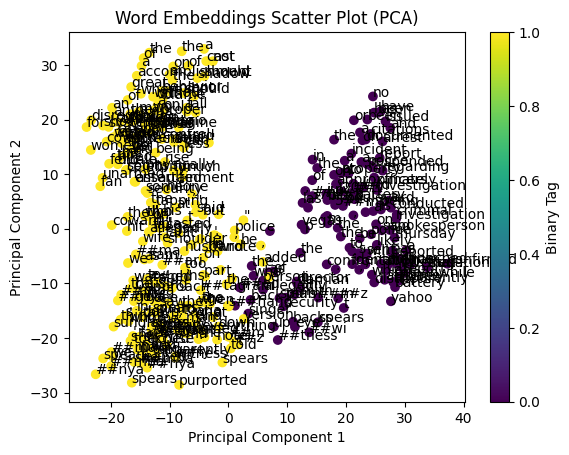

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_matrix)

# Create lists to store x and y coordinates of points
x_coords = embeddings_pca[:, 0]
y_coords = embeddings_pca[:, 1]

# Create a scatter plot
plt.scatter(x_coords, y_coords, c=cluster_labels)

# Annotate the scatter plot with the corresponding words
for i, token in enumerate(tokens):
    plt.annotate(token, (x_coords[i], y_coords[i]))

# Set labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Word Embeddings Scatter Plot (PCA)')

# Show the color bar indicating the binary tags
plt.colorbar(label='Binary Tag')

# Show the plot
plt.show()


# Step 3: Implement a Gaussian Hidden Markov Model (HMM)

Implementing a Gaussian Hidden Markov Model (HMM) is the next step in your project. The HMM will be used to determine the boundaries of entity mentions based on the IOB (Inside, Outside, Beginning) format of named entity labels. Here's an example of how you can implement the Gaussian HMM to refine the initial binary tags:

In this code snippet, we first import the necessary modules: `numpy` for array operations, `hmmlearn` for the Gaussian HMM implementation.

To prepare the training data for the HMM, we assign the word embeddings matrix `embeddings_matrix` to `X` and the initial binary tags `cluster_labels` to `y`.

Next, we convert the binary tags to IOB format. We iterate over the `iob_labels` list and modify the labels to ensure that consecutive "B" tags are converted to "I" to maintain the correct IOB format.

Then, we initialize a Gaussian HMM model with `n_components=2` to represent the two states: "B" (Beginning) and "I" (Inside).

We fit the HMM model on the training data using `model.fit(X)` to learn the underlying transition probabilities between the hidden states.

After training, we use the trained model to predict the hidden states (IOB tags) for the input embeddings `X` using `model.predict(X)`.

Finally, we map the predicted hidden states to refined tags by assigning "B" for state 0 and "I" for state 1. The refined tags are stored in the `refined_tags` list.

You can access the refined tag for a specific word (`word`) by indexing `refined_tags` using the word's index in the `tokens` list.

Please note that you might need to adjust the code based on the specific details of your implementation and the libraries you are using for the Gaussian HMM and IOB tagging.

In [18]:
try:
    from  hmmlearn import hmm
except ImportError:
    !pip install  -q  hmmlearn
    from hmmlearn import hmm


# Prepare the training data for the HMM
X = embeddings_matrix
y = np.array(cluster_labels)

# Map the binary tags to IOB format
iob_labels = ['O' if tag == '0' else 'B' for tag in binary_tags.values()]

for i in range(1, len(iob_labels)):
    if iob_labels[i] == 'B' and iob_labels[i - 1] == 'B':
        iob_labels[i] = 'I'

# Train the Gaussian HMM
model = hmm.GaussianHMM(n_components=2)
model.fit(X)

# Predict the hidden states (IOB tags) using the trained model
hidden_states = model.predict(X)

# Refine the initial binary tags with the predicted hidden states
refined_tags = ['B' if state == 0 else 'I' for state in hidden_states]


# Combine the tokens and refined tags into tagged tokens
tagged_tokens = list(zip(tokens, refined_tags))

# Single-word NE Discrimination
max_ne_prob = max(model.predict_proba(X)[:, 0])  # Maximum probability of being an NE

for i in range(len(tagged_tokens)):
    token, tag = tagged_tokens[i]

    if tag == 'B' and model.predict_proba(X)[i, 0] < 0.5 * max_ne_prob and token not in coarse_ne_dictionary:
        tagged_tokens[i] = (token, 'O')  # Modify tag to non-NE




# Step 4: Refine Gaussian HMM Output:

1. Single-word NE Discrimination:
   After obtaining the tags from the Gaussian HMM output, you can check if a single-word entity (identified as 'B') has a probability of being an NE that is less than half the maximum probability of being an NE. Additionally, you can verify if it appears in the coarse NE dictionary generated during the clustering step. If both conditions are met, you can modify the tag to a non-NE type ('O'). Here's an example:


2. High-Quality Phrase Identification:
   To address the issue of long named entities being incorrectly divided into several shorter ones, you can utilize word co-occurrence information in the corpus to identify high-quality phrases. One common approach is to use statistical measures such as pointwise mutual information (PMI) or tf-idf to determine the strength of word co-occurrence. You can create candidate entity spans by dividing words within high-quality phrases into boundary and internal parts. The specific implementation for this step depends on the details of your corpus and the method used for identifying high-quality phrases.

It's important to note that the code provided above is just a general guideline for implementing these refinements. You will need to adapt it based on the specific requirements and characteristics of your NER project, including the data, domain, and available resources.

Remember to carefully consider the thresholds, measures, and techniques used for discrimination and high-quality phrase identification, as they can greatly impact the performance and accuracy of your NER system.

In [20]:
# Predict the hidden states (tags) probabilities using the trained model
state_probs = model.predict_proba(X)

# Obtain the probabilities of being an NE
ne_probs = state_probs[:, 0]  # Probabilities of being an NE

# Find the maximum probability of being an NE
max_ne_prob = max(ne_probs)  # Maximum probability of being an NE



for i in range(len(tagged_tokens)):
    token, tag = tagged_tokens[i]

    if tag == 'B' and model.predict_proba(X)[i, 0] < 0.5 * max_ne_prob and token not in coarse_ne_dictionary:
        tagged_tokens[i] = (token, 'O')  # Modify tag to non-NE


# Step 5: Implement Deep Autoencoding Gaussian Mixture Model (DAGMM)
This model is used for determining the types of the identified named entities. It operates in two main parts: •	Compression Network: This part reduces dimensionality and combines the reduced low-dimensional representation with the reconstruction error features. •	Estimation Network: This part performs density estimation through the Gaussian Mixture Model using the reduced representation from the compression network.

Defining the optimal dimensions for the input, hidden, and latent layers in the compression network (autoencoder) is a task that often requires experimentation and tuning. However, here are some guidelines to help you determine suitable values:

1. Input Dimension (`input_dim`):
   The input dimension represents the dimensionality of the input data to the autoencoder. In the context of NER, it typically corresponds to the dimensionality of the word embeddings you are using. For example, if you are using BERT embeddings, the input dimension would be 768. Make sure to match the input dimension to the dimensionality of your word embeddings or the features you are feeding into the autoencoder.

2. Hidden Dimension (`hidden_dim`):
   The hidden dimension represents the dimensionality of the hidden layer in the autoencoder. It acts as an intermediate layer between the input and the latent representation. The hidden dimension can be chosen based on the complexity of the data and the level of abstraction you want the hidden layer to capture. Common values for the hidden dimension range from 128 to 512. You can start with a moderate value and adjust it based on the performance and capacity of your model.

3. Latent Dimension (`latent_dim`):
   The latent dimension represents the dimensionality of the reduced representation obtained from the compression network. It is the bottleneck layer of the autoencoder where the information is compressed. The latent dimension should be smaller than the input dimension to ensure dimensionality reduction. However, it should still retain enough information to capture the essential features. Choosing an appropriate latent dimension depends on the complexity of the data and the level of compression desired. Common values for the latent dimension range from 16 to 256.

To determine the optimal dimensions, you can perform hyperparameter tuning and experiment with different values. You can use techniques like grid search or random search to explore a range of values and evaluate the performance of the autoencoder on a validation set. Consider the trade-off between dimensionality reduction and preserving relevant information when selecting the dimensions.

It's important to note that the optimal dimensions may vary depending on the specific characteristics of your NER task, the complexity of the data, and the available computational resources. Experimentation and evaluation will help you identify the dimensions that yield the best performance for your particular scenario.

Feel free to adjust the values for `input_dim`, `hidden_dim`, and `latent_dim` based on your requirements and the guidelines mentioned above.

In [24]:
import torch
import torch.nn as nn

# Define the architecture of the compression network (autoencoder)
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the dimensions for the input, hidden, and latent layers
input_dim = 768  # Dimensionality of the input data (e.g., BERT embeddings)
hidden_dim = 256  # Dimensionality of the hidden layer
latent_dim = 64  # Dimensionality of the latent representation

# Create an instance of the autoencoder (compression network)
autoencoder = Autoencoder(input_dim, hidden_dim, latent_dim)

# Move the autoencoder to the desired device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

# Prepare the input data for training the autoencoder
# You can use the embeddings_matrix obtained previously

# Define the loss function and optimizer for training the autoencoder
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 10  # Number of training epochs

for epoch in range(num_epochs):
    optimizer.zero_grad()
    inputs = torch.tensor(embeddings_matrix, dtype=torch.float32).to(device)
    encoded, decoded = autoencoder(inputs)
    loss = criterion(decoded, inputs)
    loss.backward()
    optimizer.step()

# Get the reduced representations (encoded features) from the compression network
encoded_features, _ = autoencoder(torch.tensor(embeddings_matrix, dtype=torch.float32).to(device))


# Step 6:	Implement Refinement Process using Reinforcement Learning (RL)
This step is necessary to improve the quality of the initially annotated sentences. Two components are used here: •	NE Tagger: It is responsible for tagging words or phrases in the text as named entities. •	Instance Selector: This acts as an agent in the RL setup, choosing which sentences to select for further processing based on a policy network and a reward mechanism. The reward mechanism is derived from the NE tagger's ability to predict labels for selected sentences. The NE tagger and instance selector are trained iteratively.

Here's a high-level outline of how you can implement the refinement process using reinforcement learning (RL):

1. NE Tagger:
   - Prepare your annotated data: Create a dataset with sentences annotated with named entity labels. (As discussed earlier)
   - Split the data into training and validation sets.
   - Define and train the NE Tagger model using the training data. You can use a sequence labeling model like BiLSTM-CRF or a transformer-based model like BERT. (As discussed earlier)

2. Instance Selector:
   - Define the RL framework: Determine the state representation, action space, and reward mechanism for the Instance Selector.
   - Initialize the policy network: This network takes the state representation as input and outputs the probabilities of selecting each sentence.
   - Define the RL training loop: Iteratively update the policy network using a reinforcement learning algorithm like REINFORCE or Proximal Policy Optimization (PPO).
   - Training iterations: In each iteration, the Instance Selector selects a batch of sentences based on the policy network's probabilities, and the NE Tagger predicts named entity labels for the selected sentences.
   - Compute rewards: Use the NE Tagger's predictions to compute rewards for the Instance Selector. The rewards can be based on metrics like F1 score, precision, or recall of the named entity labels.
   - Update the policy network: Use the rewards to update the policy network through gradient ascent, maximizing the expected rewards.
   - Repeat the training loop for a sufficient number of iterations to refine the selection process and improve performance.

Below is a code snippet that demonstrates a simplified example of the RL training loop for the Instance Selector:

```python
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the RL policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(state_dim, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        logits = self.fc(state)
        action_probs = self.softmax(logits)
        return action_probs

# Define the reward function
def compute_reward(predictions, selected_sentences):
    # Compute the reward based on the predictions and selected sentences
    # You can use metrics like F1 score, precision, or recall

    # Example reward computation
    reward = np.mean(predictions)  # Assuming predictions are probabilities

    return reward

# Initialize the Instance Selector policy network
state_dim = <state_dimension>  # Dimensionality of the state representation
action_dim = <action_dimension>  # Dimensionality of the action space

policy_net = PolicyNetwork(state_dim, action_dim)

# Define the RL optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

# RL training loop
num_iterations = <num_iterations>  # Number of RL training iterations

for iteration in range(num_iterations):
    # Select a batch of sentences using the policy network's probabilities
    state = <construct_state_representation>  # Construct the state representation
    action_probs = policy_net(torch.tensor(state, dtype=torch.float32))
    selected_indices = torch.multinomial(action_probs, num_samples=<batch_size>, replacement=False)

    # Perform NE tagging on the selected sentences using the NE Tagger
    selected_sentences = <get_selected_sentences>  # Get the selected sentences from the dataset
    predictions = <ne_tagger_inference>  # Perform inference using the NE Tagger

    # Compute the reward based on the predictions and selected sentences
    reward = compute_reward(predictions, selected_sentences)

    # Compute the loss using the REINFORCE algorithm
    log_probs = torch.log(action_probs)
    selected_log_probs = log_probs[selected_indices]
    loss = torch.mean(-selected_log_probs * reward)

    # Update the policy network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

Please note that this code snippet is a simplified example and may need to be adapted to your specific implementation and requirements. You would need to replace the placeholder values (`<state_dimension>`, `<action_dimension>`, `<construct_state_representation>`, `<batch_size>`, `<get_selected_sentences>`, `<ne_tagger_inference>`, etc.) with appropriate values and implement the missing parts specific to your RL setup and NE Tagger.

Also, keep in mind that RL training can be computationally expensive and time-consuming. It is advisable to run RL training on powerful hardware or consider using distributed computing techniques if necessary.

I hope this gives you a general idea of how to implement the refinement process using reinforcement learning. Feel free to modify and adapt the code to fit your specific project requirements. Let me know if you have any further questions!